## Sarcasm Detection in News Headlines

### Can we distinguish Sarcastic Headlines from the Real and Non-Sarcastic Headlines?

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, Model, layers

import warnings
import string
warnings.filterwarnings("ignore")

## 1. Import Dataset

In [2]:
df = pd.read_json('Data/Sarcasm_Headlines_Dataset_v2.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## 2. Exploratory Data Analysis

### 2.1 Distribution of data across labels

In [3]:
df['is_sarcastic'].value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

The data appears to be fairly balanced for the two classes

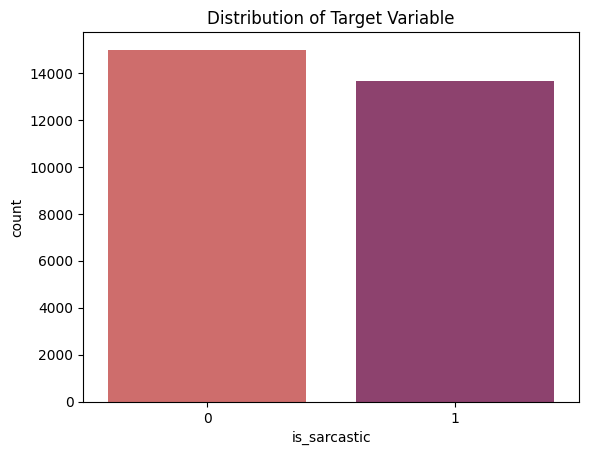

In [4]:
# Plot for the distribution of the target variable
sns.countplot(x='is_sarcastic', data=df, palette='flare')
plt.title('Distribution of Target Variable')
plt.show()

### 2.2 Word Cloud for each class

#### 2.2.1 Word Cloud for 'Sarcastic Headlines'

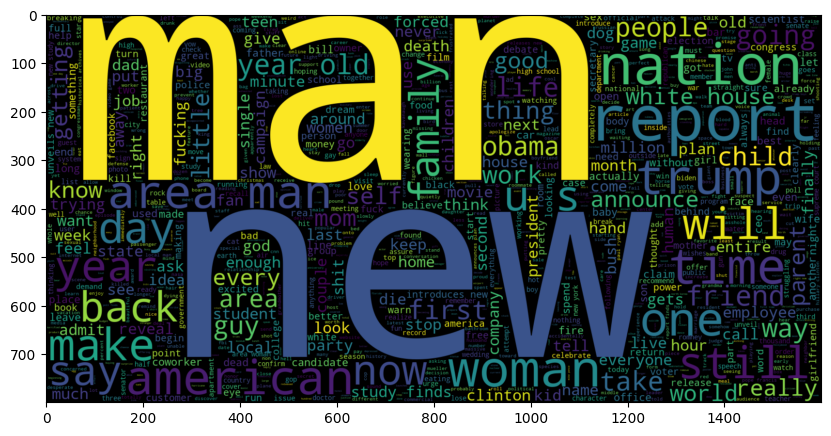

In [5]:
from wordcloud import WordCloud, STOPWORDS

# Plot for the most common words in the headlines for sarcastic news
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.is_sarcastic==1].headline))
plt.imshow(wc, interpolation='bilinear')

Word clouds are useful resource to determine the trends in words for each class. For saracstic headlines, the words - 'man', 'new', 'report', 'nation', 'make' and 'time' are among the most common words

### 2.2.2 Word Cloud for 'Non-Sarcastic Headlines'

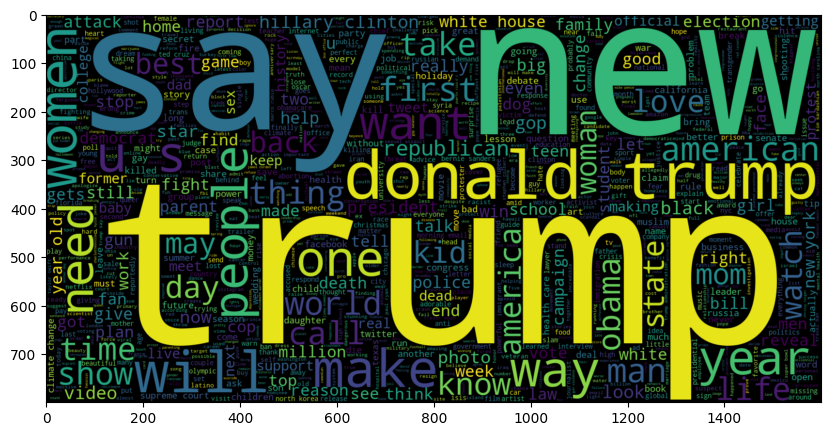

In [6]:
# Plot for the most common words in the headlines for real news
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.is_sarcastic==0].headline))
plt.imshow(wc, interpolation='bilinear')

The most common words in non-sarcastic headlines are 'Trump', 'new', 'donald', 'say', 'will' and 'one'

### 2.3 Distriubtion of headline length for each class

In [7]:
df['headline_len'] = df.headline.apply(lambda x: len(x.split()))
df.head()

,is_sarcastic,headline,article_link,headline_len
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9


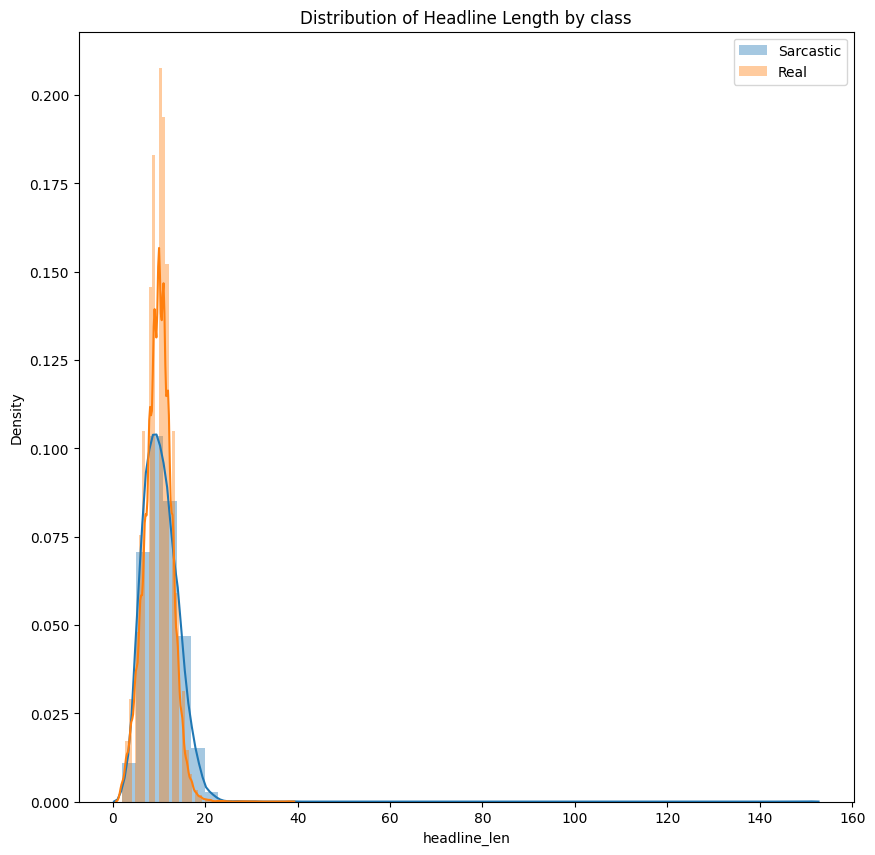

In [8]:
plt.figure(figsize=(10,10))
sns.distplot(df[df.is_sarcastic==1].headline_len, kde=True, hist=True, label='Sarcastic')
sns.distplot(df[df.is_sarcastic==0].headline_len, kde=True, hist=True, label='Real')
plt.legend()
plt.title('Distribution of Headline Length by class')
plt.show()

## 3. Data Preprocessing

Since the data i.e the headlines seems to void of any spell error or informal usages, simple data preprocessing would be sufficient to proceed further

In [9]:
from nltk.stem import WordNetLemmatizer

def clean_headlines(text):
    """
    Function to clean the headline text
    Input : Headline
    Output : Cleaned headline
    """

    # Remove punctuations
    cleaned_text = "".join([char for char in text if char not in string.punctuation])

    # Remove stopwords
    cleaned_text = " ".join([word for word in cleaned_text.split() if word not in STOPWORDS])

    # Convert to lowercase
    cleaned_text = cleaned_text.lower()

    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    cleaned_text = " ".join([lemmatizer.lemmatize(word) for word in cleaned_text.split()])

    return cleaned_text

In [10]:
df['headline_cleaned'] = df.headline.apply(lambda x: clean_headlines(x))
df.head()

,is_sarcastic,headline,article_link,headline_len,headline_cleaned
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,dem rep totally nail congress falling short ge...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,eat veggie 9 deliciously different recipe
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,mother come pretty close using word streaming ...


## 4. Split data into train and test set

### 4.1 Train-Test-Split

In [11]:
headlines = df['headline_cleaned']
labels = df['is_sarcastic']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(headlines, labels, test_size=0.2, random_state=42)

In [13]:
y_train.value_counts()

is_sarcastic
0    11990
1    10905
Name: count, dtype: int64

#### 4.2 Tokenization

In [14]:
# Hyperparameters for tokenizer
max_words = 15000
max_len = 100

# OOV words to be used for words not seen during training
oov_token = '<OOV>'
padding_type = 'post'
truncate_type = 'post'

In [15]:
# Tokenize the text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [16]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len, padding=padding_type, truncating=truncate_type)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len, padding=padding_type, truncating=truncate_type)

In [17]:
X_train.shape, X_test.shape

((22895, 100), (5724, 100))

## 5.Predictive Models

The objective is to build a binary classification model when given a sequence of headlines classifies the headline as sarcastic or not.

### 5.1 Neural Network

In [18]:
model = Sequential([
    layers.Dense(128, activation='relu', input_shape=(max_len,)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [19]:
def compile_model():
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10
    )

    print(history)
    return history

In [20]:
history = compile_model()

Epoch 1/10
716/716 [==============================] - 1s 762us/step - loss: 20.1169 - accuracy: 0.5127 - val_loss: 0.7101 - val_accuracy: 0.5238
Epoch 2/10
716/716 [==============================] - 0s 661us/step - loss: 0.9298 - accuracy: 0.5283 - val_loss: 0.6958 - val_accuracy: 0.5232
Epoch 3/10
716/716 [==============================] - 0s 661us/step - loss: 0.7601 - accuracy: 0.5335 - val_loss: 0.6943 - val_accuracy: 0.5232
Epoch 4/10
716/716 [==============================] - 0s 660us/step - loss: 0.7389 - accuracy: 0.5331 - val_loss: 0.6929 - val_accuracy: 0.5232
Epoch 5/10
716/716 [==============================] - 0s 659us/step - loss: 0.7213 - accuracy: 0.5275 - val_loss: 0.6925 - val_accuracy: 0.5232
Epoch 6/10
716/716 [==============================] - 0s 661us/step - loss: 0.7095 - accuracy: 0.5246 - val_loss: 0.6922 - val_accuracy: 0.5232
Epoch 7/10
716/716 [==============================] - 0s 659us/step - loss: 0.7026 - accuracy: 0.5260 - val_loss: 0.6921 - val_accuracy

In [21]:
def plot_accuracy_loss(history) :
    score = model.evaluate(X_test, y_test)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

179/179 [==============================] - 0s 351us/step - loss: 0.6921 - accuracy: 0.5232
Test score: 0.692068874835968
Test accuracy: 0.5232354998588562


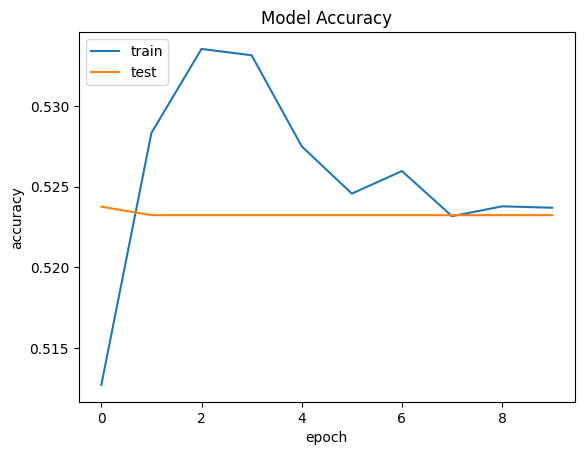

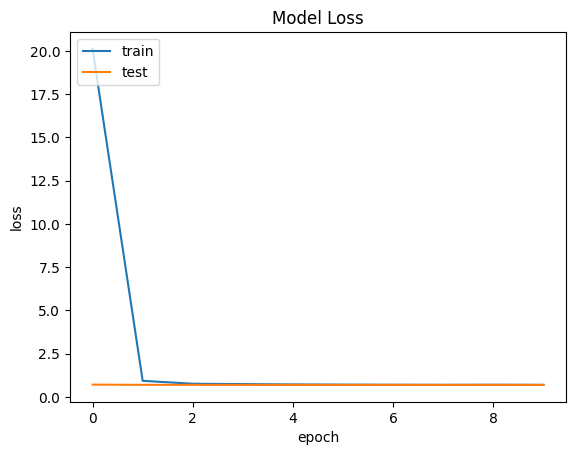

In [22]:
plot_accuracy_loss(history)

### 5.2 Neural Network with Embedding

A neural network with embedding is commonly used for NL tasks such as text classification. The embedding layer learns to represent each word as a vector in such a way that words with similar meanings are close together in the vector space 

In [32]:
model = Sequential([
    layers.Embedding(max_words, 64, input_length=max_len),
    layers.GlobalMaxPooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           960000    
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 962113 (3.67 MB)
Trainable params: 962113 (3.67 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [24]:
history = compile_model()

Epoch 1/10
716/716 [==============================] - 3s 4ms/step - loss: 0.5587 - accuracy: 0.7119 - val_loss: 0.4462 - val_accuracy: 0.7939
Epoch 2/10
716/716 [==============================] - 3s 4ms/step - loss: 0.3039 - accuracy: 0.8765 - val_loss: 0.4279 - val_accuracy: 0.8097
Epoch 3/10
716/716 [==============================] - 3s 4ms/step - loss: 0.1519 - accuracy: 0.9460 - val_loss: 0.4960 - val_accuracy: 0.8075
Epoch 4/10
716/716 [==============================] - 3s 4ms/step - loss: 0.0599 - accuracy: 0.9830 - val_loss: 0.6034 - val_accuracy: 0.8077
Epoch 5/10
716/716 [==============================] - 3s 5ms/step - loss: 0.0201 - accuracy: 0.9956 - val_loss: 0.7124 - val_accuracy: 0.8024
Epoch 6/10
716/716 [==============================] - 3s 5ms/step - loss: 0.0070 - accuracy: 0.9992 - val_loss: 0.8054 - val_accuracy: 0.8028
Epoch 7/10
716/716 [==============================] - 4s 5ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 0.8962 - val_accuracy: 0.8022
Epoch 

Clearly the model is overfitting on the data as it is observable from the train_accuracy and the validation loss values over the epochs.

<br> Let us try the ReduceLROnPlateau technique which is callback function that monitors the specified metric during training, in this case validation_loss and reduces the learning rate by a factor when the metric has stopped improving

In [30]:
from gc import callbacks


def compile_model():
    rlrp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.05, 
        patience=1)

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        callbacks=[rlrp]
    )

    print(history)
    return history

In [33]:
history = compile_model()

Epoch 1/10


716/716 [==============================] - 3s 4ms/step - loss: 0.5518 - accuracy: 0.7173 - val_loss: 0.4429 - val_accuracy: 0.7935 - lr: 0.0010
Epoch 2/10
716/716 [==============================] - 3s 4ms/step - loss: 0.3022 - accuracy: 0.8780 - val_loss: 0.4264 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 3/10
716/716 [==============================] - 3s 4ms/step - loss: 0.1481 - accuracy: 0.9480 - val_loss: 0.5025 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 4/10
716/716 [==============================] - 3s 4ms/step - loss: 0.0558 - accuracy: 0.9875 - val_loss: 0.5114 - val_accuracy: 0.8082 - lr: 5.0000e-05
Epoch 5/10
716/716 [==============================] - 3s 4ms/step - loss: 0.0502 - accuracy: 0.9898 - val_loss: 0.5120 - val_accuracy: 0.8084 - lr: 2.5000e-06
Epoch 6/10
716/716 [==============================] - 3s 4ms/step - loss: 0.0505 - accuracy: 0.9899 - val_loss: 0.5120 - val_accuracy: 0.8084 - lr: 1.2500e-07
Epoch 7/10
716/716 [==============================] - 3s 4ms/step - l

179/179 [==============================] - 0s 460us/step - loss: 0.5120 - accuracy: 0.8084
Test score: 0.5120242834091187
Test accuracy: 0.8083508014678955


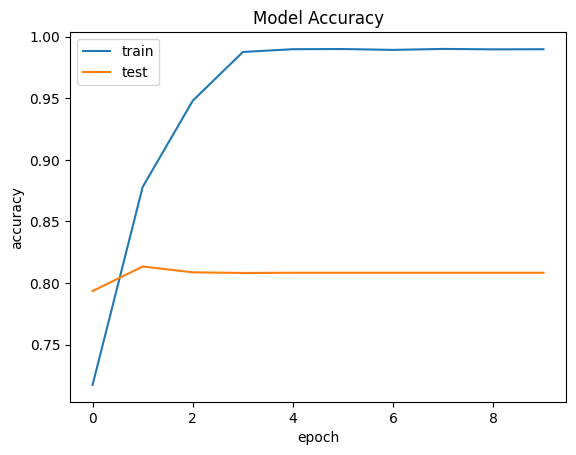

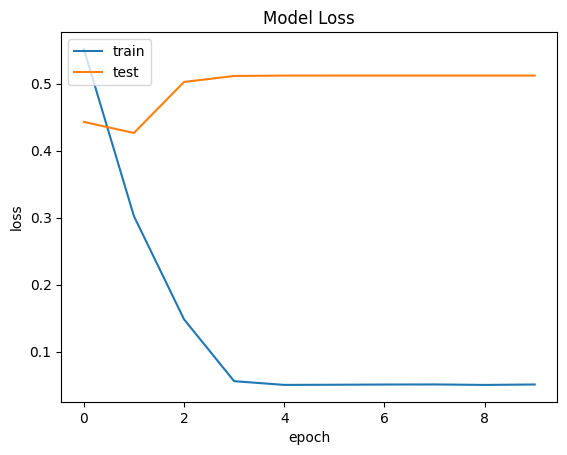

In [34]:
plot_accuracy_loss(history)

### 5.3 Recurrent Neural Network (RNN)

In [35]:
model = Sequential([
    layers.Embedding(max_words, 64, input_length=max_len),
    layers.SpatialDropout1D(0.2),
    layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    layers.GlobalMaxPooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 64)           960000    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 64)           0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 32)           3104      
                                                                 
 global_max_pooling1d_4 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)               

In [36]:
history = compile_model()

Epoch 1/10
716/716 [==============================] - 12s 16ms/step - loss: 0.6990 - accuracy: 0.5066 - val_loss: 0.6940 - val_accuracy: 0.4771 - lr: 0.0010
Epoch 2/10
716/716 [==============================] - 11s 16ms/step - loss: 0.6480 - accuracy: 0.6005 - val_loss: 0.5330 - val_accuracy: 0.7662 - lr: 0.0010
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.4624 - accuracy: 0.7865 - val_loss: 0.4692 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3613 - accuracy: 0.8456 - val_loss: 0.4648 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 5/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3059 - accuracy: 0.8697 - val_loss: 0.4713 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 6/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2455 - accuracy: 0.9011 - val_loss: 0.4934 - val_accuracy: 0.7945 - lr: 5.0000e-05
Epoch 7/10
716/716 [==============================] - 

  1/179 [..............................] - ETA: 2s - loss: 0.5567 - accuracy: 0.8125

179/179 [==============================] - 0s 2ms/step - loss: 0.4942 - accuracy: 0.7945
Test score: 0.4942382276058197
Test accuracy: 0.794549286365509


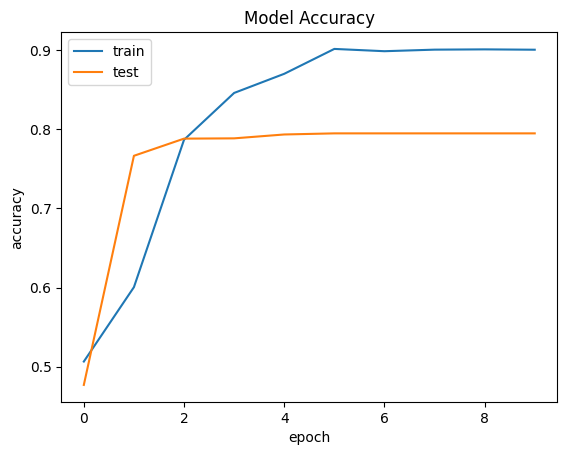

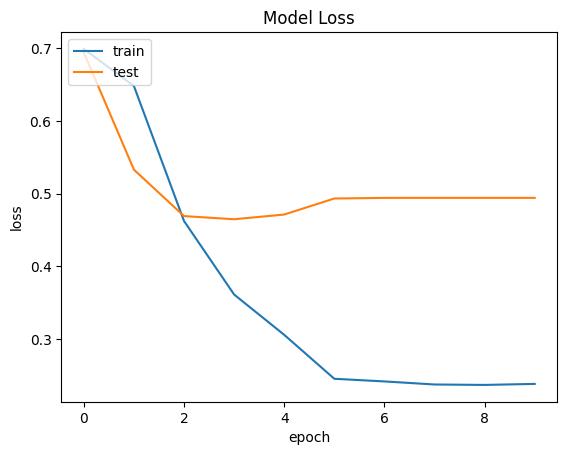

In [37]:
plot_accuracy_loss(history)

### 5.4 Long Short Term Memory (LSTM) 

In [38]:
model = Sequential([
    layers.Embedding(max_words, 64, input_length=max_len),
    layers.SpatialDropout1D(0.2),
    layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    layers.GlobalMaxPooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 64)           960000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 64)           0         
 alDropout1D)                                                    
                                                                 
 lstm (LSTM)                 (None, 100, 32)           12416     
                                                                 
 global_max_pooling1d_5 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dropout_8 (Dropout)         (None, 16)               

In [39]:
history = compile_model()

Epoch 1/10
716/716 [==============================] - 32s 44ms/step - loss: 0.5772 - accuracy: 0.6946 - val_loss: 0.4959 - val_accuracy: 0.7601 - lr: 0.0010
Epoch 2/10
716/716 [==============================] - 32s 44ms/step - loss: 0.3984 - accuracy: 0.8318 - val_loss: 0.4324 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 3/10
716/716 [==============================] - 32s 44ms/step - loss: 0.2873 - accuracy: 0.8932 - val_loss: 0.4642 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 4/10
716/716 [==============================] - 32s 45ms/step - loss: 0.1978 - accuracy: 0.9357 - val_loss: 0.4883 - val_accuracy: 0.8038 - lr: 5.0000e-05
Epoch 5/10
716/716 [==============================] - 32s 45ms/step - loss: 0.1908 - accuracy: 0.9395 - val_loss: 0.4895 - val_accuracy: 0.8038 - lr: 2.5000e-06
Epoch 6/10
716/716 [==============================] - 32s 45ms/step - loss: 0.1877 - accuracy: 0.9402 - val_loss: 0.4896 - val_accuracy: 0.8038 - lr: 1.2500e-07
Epoch 7/10
716/716 [==========================

  1/179 [..............................] - ETA: 4s - loss: 0.5407 - accuracy: 0.7812

179/179 [==============================] - 1s 5ms/step - loss: 0.4896 - accuracy: 0.8038
Test score: 0.48955875635147095
Test accuracy: 0.8038085103034973


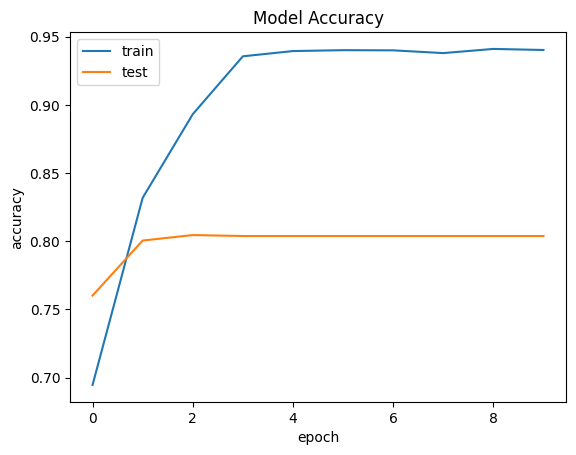

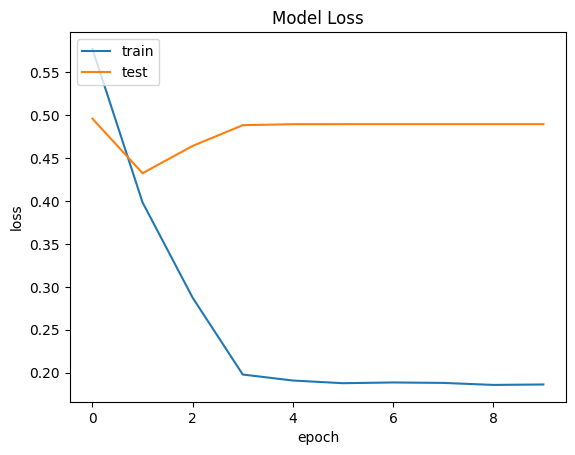

In [41]:
plot_accuracy_loss(history)

### 5.5 Stacked LSTM

The purpose of using a stacked LSTM is to increase the representational power of the model and capture more complex patterns in the input sequence. Each layer in the stack can learn to represent different levels of abstraction in the input sequence.

In [42]:
model = Sequential([
    layers.Embedding(max_words, 64, input_length=max_len),
    layers.SpatialDropout1D(0.2),
    layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    layers.GlobalMaxPooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
]) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 64)           960000    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 100, 64)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 100, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 100, 32)           8320      
                                                                 
 global_max_pooling1d_6 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_16 (Dense)            (None, 16)               

In [43]:
history = compile_model()

Epoch 1/10
716/716 [==============================] - 59s 80ms/step - loss: 0.5385 - accuracy: 0.7291 - val_loss: 0.4549 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 2/10
716/716 [==============================] - 59s 82ms/step - loss: 0.3492 - accuracy: 0.8613 - val_loss: 0.4156 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 3/10
716/716 [==============================] - 59s 82ms/step - loss: 0.2567 - accuracy: 0.9049 - val_loss: 0.4436 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 4/10
716/716 [==============================] - 58s 81ms/step - loss: 0.1605 - accuracy: 0.9476 - val_loss: 0.5103 - val_accuracy: 0.8125 - lr: 5.0000e-05
Epoch 5/10
716/716 [==============================] - 58s 81ms/step - loss: 0.1493 - accuracy: 0.9505 - val_loss: 0.5116 - val_accuracy: 0.8115 - lr: 2.5000e-06
Epoch 6/10
716/716 [==============================] - 58s 81ms/step - loss: 0.1498 - accuracy: 0.9499 - val_loss: 0.5117 - val_accuracy: 0.8118 - lr: 1.2500e-07
Epoch 7/10
716/716 [==========================

179/179 [==============================] - 2s 9ms/step - loss: 0.5117 - accuracy: 0.8118
Test score: 0.5117009878158569
Test accuracy: 0.8118448853492737


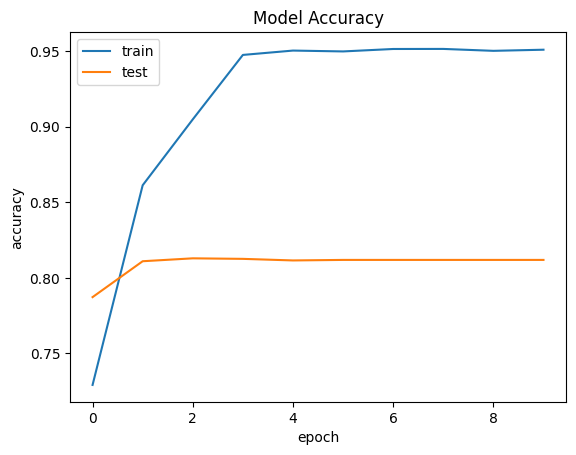

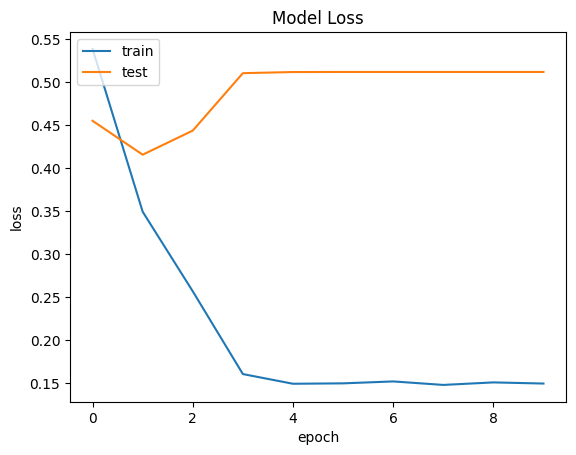

In [44]:
plot_accuracy_loss(history)

### 5.6 Stacked Bidirectional LSTM

In [45]:
model  = Sequential([
    layers.Embedding(max_words, 64, input_length=max_len),
    layers.Bidirectional(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32, recurrent_dropout=0.2)),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 64)           960000    
                                                                 
 bidirectional (Bidirection  (None, 100, 64)           24832     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 16)                1040      
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                

In [46]:
history = compile_model()

Epoch 1/10
716/716 [==============================] - 107s 145ms/step - loss: 0.4968 - accuracy: 0.7539 - val_loss: 0.4035 - val_accuracy: 0.8164 - lr: 0.0010
Epoch 2/10
716/716 [==============================] - 107s 149ms/step - loss: 0.2811 - accuracy: 0.8868 - val_loss: 0.4092 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 3/10
716/716 [==============================] - 107s 149ms/step - loss: 0.1361 - accuracy: 0.9534 - val_loss: 0.5063 - val_accuracy: 0.8173 - lr: 5.0000e-05
Epoch 4/10
716/716 [==============================] - 107s 149ms/step - loss: 0.1220 - accuracy: 0.9587 - val_loss: 0.5084 - val_accuracy: 0.8180 - lr: 2.5000e-06
Epoch 5/10
716/716 [==============================] - 107s 149ms/step - loss: 0.1233 - accuracy: 0.9593 - val_loss: 0.5085 - val_accuracy: 0.8180 - lr: 1.2500e-07
Epoch 6/10
716/716 [==============================] - 107s 149ms/step - loss: 0.1215 - accuracy: 0.9593 - val_loss: 0.5085 - val_accuracy: 0.8180 - lr: 6.2500e-09
Epoch 7/10
716/716 [==========

179/179 [==============================] - 3s 18ms/step - loss: 0.5085 - accuracy: 0.8180
Test score: 0.5084953308105469
Test accuracy: 0.8179594874382019


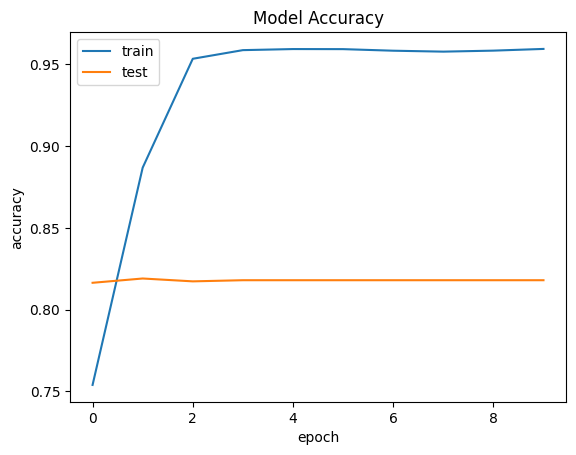

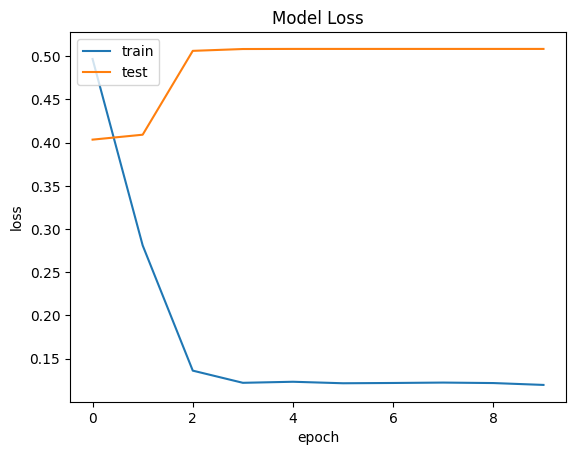

In [47]:
plot_accuracy_loss(history)

## 6. Tuning the best models

Two models have demonstrated the best performance:
1. LSTM
2. Bidirectional LSTM

#### 1. Tuning LSTM

In [48]:
model = Sequential([
    layers.Embedding(max_words, 64, input_length=max_len),
    layers.SpatialDropout1D(0.2),
    layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
    layers.GlobalMaxPooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])
    
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 64)           960000    
                                                                 
 spatial_dropout1d_3 (Spati  (None, 100, 64)           0         
 alDropout1D)                                                    
                                                                 
 lstm_5 (LSTM)               (None, 100, 32)           12416     
                                                                 
 global_max_pooling1d_7 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)        (None, 16)               

In [49]:
history = compile_model()

Epoch 1/10
716/716 [==============================] - 32s 44ms/step - loss: 0.5483 - accuracy: 0.7214 - val_loss: 0.4392 - val_accuracy: 0.7996 - lr: 0.0010
Epoch 2/10
716/716 [==============================] - 31s 44ms/step - loss: 0.3587 - accuracy: 0.8553 - val_loss: 0.4166 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 3/10
716/716 [==============================] - 32s 44ms/step - loss: 0.2780 - accuracy: 0.8951 - val_loss: 0.4249 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 4/10
716/716 [==============================] - 32s 44ms/step - loss: 0.1958 - accuracy: 0.9356 - val_loss: 0.5008 - val_accuracy: 0.8110 - lr: 5.0000e-05
Epoch 5/10
716/716 [==============================] - 32s 44ms/step - loss: 0.1862 - accuracy: 0.9383 - val_loss: 0.5004 - val_accuracy: 0.8099 - lr: 2.5000e-06
Epoch 6/10
716/716 [==============================] - 2394s 3s/step - loss: 0.1869 - accuracy: 0.9393 - val_loss: 0.5004 - val_accuracy: 0.8099 - lr: 1.2500e-07
Epoch 7/10
716/716 [==========================

179/179 [==============================] - 1s 5ms/step - loss: 0.5004 - accuracy: 0.8099
Test score: 0.5004194378852844
Test accuracy: 0.8099231123924255


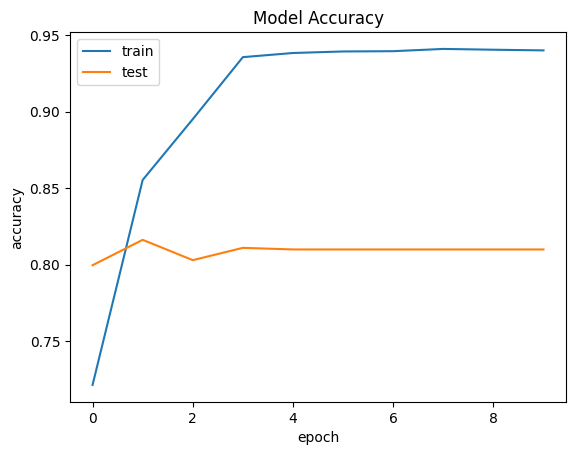

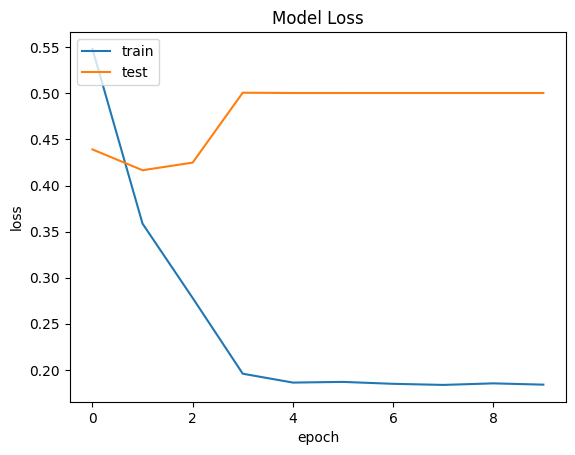

In [50]:
plot_accuracy_loss(history)